# Regression

### Housing Price Prediction

The goal of this competition entry is apply concepts I've learnt so far, and gain more practise in feature engineering and stacked models.

As the missing features of this dataset are rather sparse, engineering them will mainly mean:

* Imputing missing values
* Dealing with outliers
* Transforming variables
* Label Encoding
* Stabilizing variance/skewness
* Aquiring dummy variables

Model will be a sklearn base + XGBoost + LightGBM stack predicting the **SalePrice**.

### Credits & Inspiration
* [Stacked Regression by Serigne](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard/notebook) - Absolutely stunning notebook that I've used as the template for my own explorations here. Taught me a lot about feature engineering and stacked modelling.
* [Stacking Ensemble Machine Learning With Python by Jason Brownlee](https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/) - Great tutorial on stacking models
* [Comprehensive data exploration with Python by Pedro Marcelino](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python) - In-depth EDA on this dataset
* [A study on Regression applied to the Ames dataset by juliencs](https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset) - Great notebook using linear regression on this dataset
* [Missing Values, Ordinal data and stories
 by mitra mirshafiee](https://www.kaggle.com/mitramir5/missing-values-ordinal-data-and-stories) - Illustrative and educational notebook on handling missing values

In [44]:

import numpy as np
import pandas as pd

#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = [12,6]
sns.set(style="darkgrid")

#Statistics
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p

#Float Output to 2 decimals
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))

#Models
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, RobustScaler
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

#Quality of life
import warnings
warnings.filterwarnings('ignore')

In [88]:
#Importing datasets
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [89]:
#First look training set
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.00,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.00,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.00,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.00,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [90]:
#First look test set
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.00,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.00,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.00,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.00,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.00,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [91]:
#Saving then dropping Id column as it does not impact our prediction
train_ID = train['Id']
test_ID = test['Id']

train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

### Outliers

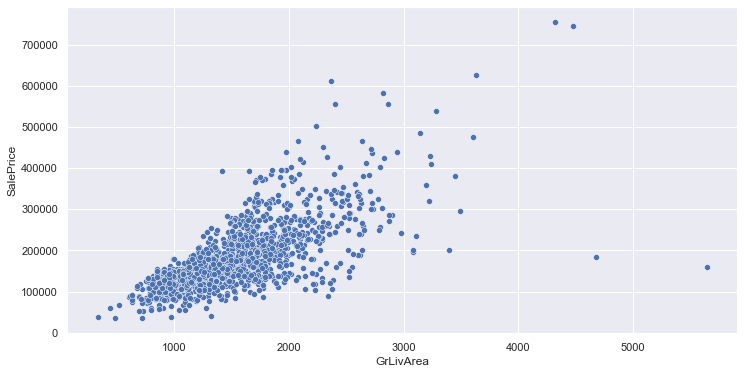

In [92]:
#visualizing outliers, seen in bottom right.
sns.scatterplot(data=train, x='GrLivArea', y='SalePrice');

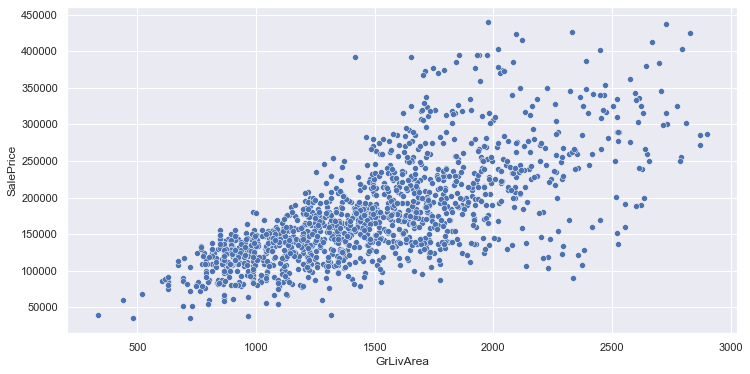

In [93]:
df = pd.concat((train, test)).reset_index(drop=True)

GrLivArea_quantile = df["GrLivArea"].quantile(0.99)
SalePrice_quantile = df["SalePrice"].quantile(0.99)

df = df[(df["SalePrice"] < SalePrice_quantile) & (df["GrLivArea"] < GrLivArea_quantile)]

sns.scatterplot(data=df, x='GrLivArea', y='SalePrice');

In [94]:
df.nunique()

MSSubClass         15
MSZoning            5
LotFrontage       108
LotArea          1047
Street              2
                 ... 
MoSold             12
YrSold              5
SaleType            9
SaleCondition       6
SalePrice         641
Length: 80, dtype: int64

### Univariate Analysis SalePrice

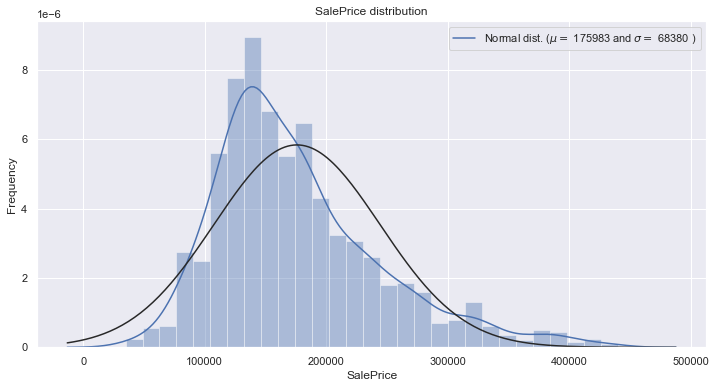

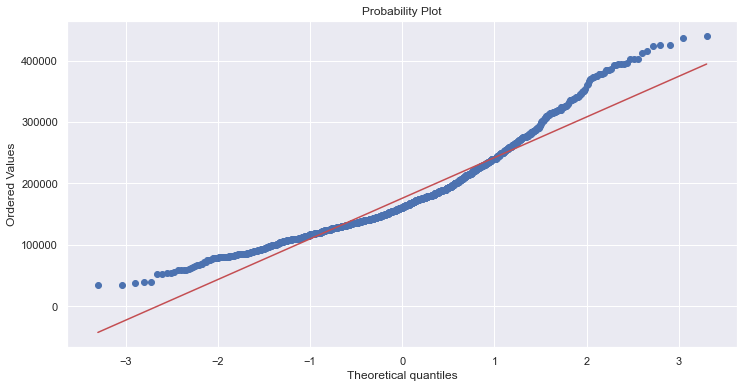

In [95]:
sns.distplot(df['SalePrice'] , fit=norm);

#Fitted parameters used by function
(mu, sigma) = norm.fit(df['SalePrice'])

#Visualize Normal Distribution
plt.legend(['Normal dist. ($\mu=$ {:.0f} and $\sigma=$ {:.0f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Visualize Quantile-Quantile plot
fig = plt.figure()
res = stats.probplot(df['SalePrice'], plot=plt)
plt.show()

The target variable is right skewed, which is a problem for our model as it needs to be normally distributed. This means we need to apply a Log transformation.

### Log transformation

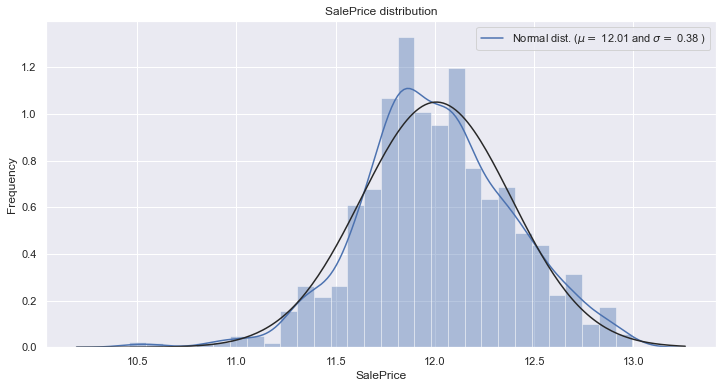

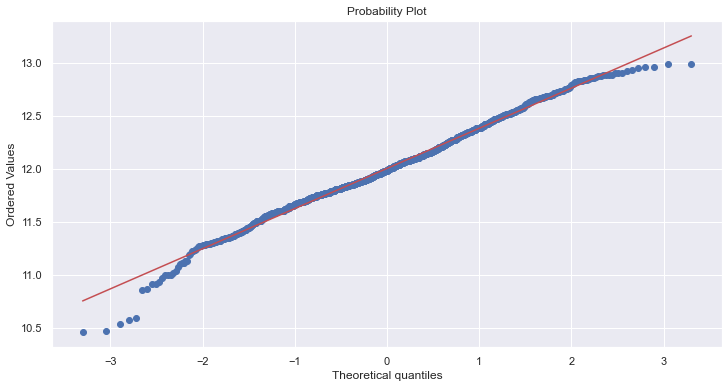

In [96]:
#Using numpy log1p fuction, which applies log(1+x) to elements of the column
df["SalePrice"] = np.log1p(df["SalePrice"])

sns.distplot(df['SalePrice'] , fit=norm);

#Fitted parameters used by function
(mu, sigma) = norm.fit(df['SalePrice'])

#Visualize Normal Distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Visualize Quantile-Quantile plot
fig = plt.figure()
res = stats.probplot(df['SalePrice'], plot=plt)
plt.show()

The SalePrice has been transformed to be normally distributed.

### Data Correlation

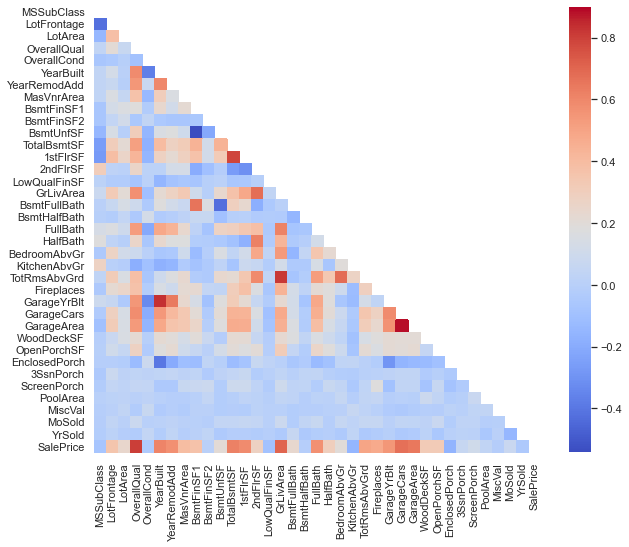

In [97]:
#Correlation map to understand how other features relate to SalePrice
corrmat = df.corr()
mask = np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):

    f, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(corrmat, mask=mask, ax=ax, cbar_kws={"shrink": .82},vmax=.9, cmap='coolwarm', square=True)

We can immediately spot how the OverallQual and GrLivArea features have the high positive correlation with SalePrice.

### Feature Engineering
Concatenating training and test set into same dataframe for preprocessing. Our feature engineering mainly revolves around harmonizing values so they more accurately reflect reality, whilst increasing predictions.

*version 6 note: **data leakage will occur** since we impute values based on test+train datasets, leading to a too optimistic score. In future version we will calculate compute missing values and apply Box-Cox seperately.*

In [98]:
#Creating index for splitting datasets
i_train = train.shape[0]
i_test = test.shape[0]

#Setting y_train
y_train = train.SalePrice.values

#Concatenating datasets
df_concat = pd.concat((train, test))
df_concat.drop(['SalePrice'], axis=1, inplace=True)

#Printing shape of datasets
print(train.shape)
print(test.shape)
print(df_concat.shape)

(1460, 80)
(1459, 79)
(2919, 79)


### Missing Data

In [99]:
#Creating dataframe with percentages of missing values
df_concat_na = (df_concat.isnull().sum() / len(df_concat)) * 100

#Sorting by percentages of missing values
df_concat_na = df_concat_na.sort_values(ascending=False)[:20] #values of missing percentages after index 20 drop to around 0.03.. 

missing_values = pd.DataFrame({'Missing %' :df_concat_na})
missing_values.head()

,Missing %
PoolQC,99.66
MiscFeature,96.40
Alley,93.22
Fence,80.44
FireplaceQu,48.65


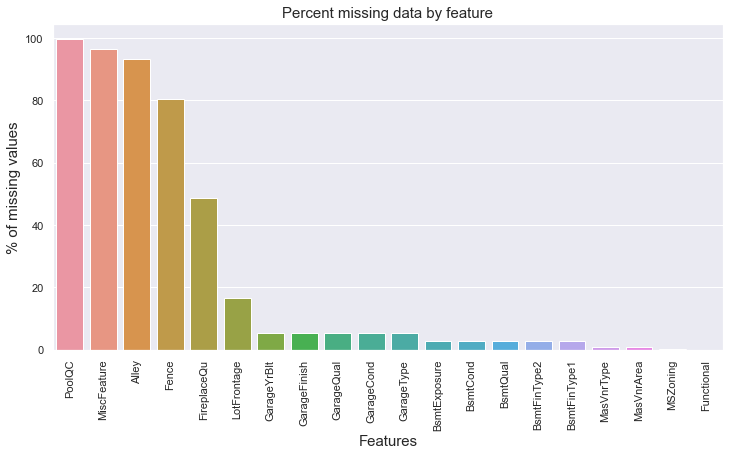

In [100]:
#Visualizing missing values by feauture
sns.barplot(x=df_concat_na.index, y=df_concat_na)
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('% of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15);

We clearly see on where we need to focus our work.
1. Coming up with a strategy to the missing values with over 80% NAs
2. Defining approach in imputing other missing values 

### Imputing Missing Values
We will handle missing values by descending order of %NA. For each feature we'll first learn what we can from the description provided with the datasets, and secondly, provide our method for dealing with the missing values.

In [101]:
to_drop = list(df_concat_na[df_concat_na>30].index)
df.drop(to_drop,axis=1,inplace=True)

**LotFrontage**: Linear feet of street connected to property

We assume here that neighborhoods contrain similar houses to fill in missing values by median LotFrontage per Neighborhood. Computing median has to be split per dataset, so as to not cause data leakage.

In [102]:
df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

**GarageType**: Garage location
		
       2Types	More than one type of garage
       Attchd	Attached to home
       Basment	Basement Garage
       BuiltIn	Built-In (Garage part of house - typically has room above garage)
       CarPort	Car Port
       Detchd	Detached from home
       NA	No Garage
		
**GarageFinish**: Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage

**GarageQual**: Garage quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
		
**GarageCond**: Garage condition

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
       
NA means lack of this feature, so we fill missing values with None       

In [105]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    df[col].fillna('None',inplace=True)

**GarageYrBlt**: Year garage was built

**GarageCars**: Size of garage in car capacity

**GarageArea**: Size of garage in square feet

Missing numerical values will be replaced by 0

In [106]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars','BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtHalfBath', 'BsmtFullBath'):
    avg=df[col].mean()
    df[col].fillna(avg,inplace=True)

**BsmtQual**: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement
		
**BsmtCond**: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement
	
**BsmtExposure**: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement
	
**BsmtFinType1**: Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
		
**BsmtFinType2**: Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
       
NA means lack of this feature, so we fill missing values with None.       

In [121]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):    
    df[col].fillna('None', inplace=True)

**BsmtFinSF1**: Type 1 finished square feet

**BsmtFinSF2**: Type 2 finished square feet

**BsmtUnfSF**: Unfinished square feet of basement area

**TotalBsmtSF**: Total square feet of basement area

**BsmtFullBath**: Basement full bathrooms

**BsmtHalfBath**: Basement half bathrooms

Missing numerical values will be replaced by 0

In [108]:
df['MasVnrType'].fillna('None',inplace=True)

**MasVnrArea** : Masonry veneer area in square feet
As an architect I'm astonished this feature even exists. We assume missing values mean no masonry veneer, meaning 0.

In [111]:
df['MasVnrArea'].fillna(0,inplace=True)

**MSZoning**: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density
       
As RL is by far the most common, we take the mode and fill in missing values with RL.       

In [112]:
df['MSZoning'].fillna(df['MSZoning'].value_counts().idxmax(), inplace=True)

**Utilities**: Type of utilities available
		
       AllPub	All public Utilities (E,G,W,& S)	
       NoSewr	Electricity, Gas, and Water (Septic Tank)
       NoSeWa	Electricity and Gas Only
       ELO	Electricity only
       
The value of this feauture is AllPub for most of the dataset, with only 1 NoSeWa feauture. We can fately assume this feauture will not be helpful in predictive modelling, and will remove it.      

In [113]:
df['Utilities'].value_counts()

AllPub    1430
NoSeWa       1
Name: Utilities, dtype: int64

In [114]:
df.drop(['Utilities'], axis=1, inplace=True)

**Functional**: Home functionality (Assume typical unless deductions are warranted)

       Typ	Typical Functionality
       Min1	Minor Deductions 1
       Min2	Minor Deductions 2
       Mod	Moderate Deductions
       Maj1	Major Deductions 1
       Maj2	Major Deductions 2
       Sev	Severely Damaged
       Sal	Salvage only
       
Any missing values will be transformed to Typ.     

In [115]:
df['Functional'].fillna(df['Functional'].value_counts().idxmax(), inplace=True)

**Electrical**: Electrical system

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed
       
It's only NA value will be set to SBrkr.       

In [116]:
df['Electrical'].fillna(df['Electrical'].value_counts().idxmax(), inplace=True)

**KitchenQual**: Kitchen quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       
We replace its only missing value by the mode of TA       

In [117]:
df['KitchenQual'].fillna(df['KitchenQual'].value_counts().idxmax(), inplace=True)

**Exterior1st**: Exterior covering on house
**Exterior2nd**: Exterior covering on house (if more than one material)

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast	
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles

Since both have a single missing value we again replace the most common string as the missing value.

In [118]:
df['Exterior1st'].fillna(df['Exterior1st'].value_counts().idxmax(), inplace=True)
df['Exterior2nd'].fillna(df['Exterior2nd'].value_counts().idxmax(), inplace=True)

**SaleType**: Type of sale
		
       WD 	Warranty Deed - Conventional
       CWD	Warranty Deed - Cash
       VWD	Warranty Deed - VA Loan
       New	Home just constructed and sold
       COD	Court Officer Deed/Estate
       Con	Contract 15% Down payment regular terms
       ConLw	Contract Low Down payment and low interest
       ConLI	Contract Low Interest
       ConLD	Contract Low Down
       Oth	Other
       
Missing values will be filled with most frequent type WD       

In [119]:
df['SaleType'].fillna(df['SaleType'].value_counts().idxmax(), inplace=True)

**Missing Values Check**

In [122]:
#Creating dataframe with percentages of missing values
df_concat_na = (df.isnull().sum() / len(df)) * 100

#Sorting by percentages of missing values
df_concat_na = df_concat_na.sort_values(ascending=False) 

missing_values = pd.DataFrame({'Missing %' :df_concat_na})
missing_values

,Missing %
MSSubClass,0.00
GarageYrBlt,0.00
Fireplaces,0.00
Functional,0.00
TotRmsAbvGrd,0.00
...,...
ExterQual,0.00
MasVnrArea,0.00
MasVnrType,0.00
Exterior2nd,0.00


In [125]:
#MSSubClass
df['MSSubClass'].astype(str)


#Changing OverallCond into a categorical variable
df['OverallCond'] = df['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
df['YrSold'] = df['YrSold'].astype(str)
df['MoSold'] = df['MoSold'].astype(str)

In [130]:
#List of features to encode
cols = ('BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

#Applying LabelEncoder to categorical features
for i in cols:
    le = LabelEncoder() 
    le.fit(list(df[i].values)) 
    df[i] = le.transform(list(df[i].values))

**Adding a Total sqf feature**

Since we've seen the correlation between square footage on SalePrice, adding a feature combing all seperate parameters together seems logical as a great predictor. 

In [131]:
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

In [132]:
df.drop(["TotalBsmtSF","1stFlrSF","2ndFlrSF"],axis=1,inplace=True)

### Skewness and Box Cox Transformation
Calculating degree of skewness and computing Box Cox transformation of 1 + x

*Note: applying Box Cox transformation to both datasets at once will lead to data leakage and will be addressed in future versions.*

In [146]:
numeric_feats = df.dtypes[df.dtypes != "object"].index

#Check the skew of all numerical features
skewed_feats = df[numeric_feats].apply(skew).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)

,Skew
MiscVal,24.21
PoolArea,19.33
LotArea,12.87
LowQualFinSF,10.39
3SsnPorch,10.19
LandSlope,4.87
KitchenAbvGr,4.47
BsmtFinSF2,4.26
ScreenPorch,4.13
BsmtHalfBath,4.12


In [157]:
skewness = skewness[abs(skewness.Skew)>0.75]
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #df_concat[feat] += 1
    df[feat] = boxcox1p(df[feat], lam)

**Dummy Variables**

In [158]:
df = pd.get_dummies(df)

In [169]:
from sklearn.model_selection import train_test_split
X = df.drop("SalePrice",axis=1)
y = df.SalePrice
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [170]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [175]:
y_pred = regressor.predict(X_test)
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.08399581484207481
Mean Squared Error: 0.014729486408912995
Root Mean Squared Error: 0.12136509551313752


In [176]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.9004116363295784